In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import numpy as np

In [2]:
db = pd.read_csv('../data/dbNSFP3.2.clinvar_clean.txt',
                  sep='\t')

/Users/d/work/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (1,8,9,10,11,67,68,69,70,71,72,73,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,107,108) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
db.drop_duplicates().shape

(38405, 186)

In [4]:
db['aa_change'] = db['aaref'] + '=>' + db['aaalt']

## Create simple table for just proteins with glycosylation sites with distance annotation

In [5]:
p_d = pd.read_csv('../data/protein_aa_distance.txt',
                       sep='\t',
                       header=None,index_col=0)

In [6]:
p_d.columns = ['protein','aa','distance_to_feature']

In [7]:
db = db[['aapos','Uniprot_acc_Polyphen2','clinvar_pathogenic','aa_change']]
db = db[db['Uniprot_acc_Polyphen2'] != '.']
db.head()

,aapos,Uniprot_acc_Polyphen2,clinvar_pathogenic,aa_change
3,215;353,O00468,likely benign,Q=>R
4,590;728,O00468,benign,E=>V
5,950;1088,O00468,likely benign,L=>F
6,997;1135,O00468,likely benign,Q=>R
7,1151;1289,O00468,likely benign,P=>L


## Going through the clinvar database and matching amino acids


In [8]:
aas = []
proteins = []
clinvars = []
aa_changes = []
i_s = []
for i in db.index:
    one_var = db.loc[i]
    aa_list = one_var['aapos'].split(';')
    protein_list = one_var['Uniprot_acc_Polyphen2'].split(';')
    path = one_var['clinvar_pathogenic']
    aa_change = one_var['aa_change']
    for p in protein_list:
        for aa in aa_list:
            aas.append(aa)
            proteins.append(p)
            clinvars.append(path)
            aa_changes.append(aa_change)
            i_s.append(i)

In [9]:
flat_db = pd.DataFrame([pd.Series(aas,dtype=int),
                  pd.Series(proteins),
                  pd.Series(clinvars),
                  pd.Series(aa_changes),
                  pd.Series(i_s)])
flat_db = flat_db.transpose()
flat_db.columns = ['aa','protein','clinvar_path','aa_change','clinvar_index']

/Users/d/work/conda/lib/python3.7/site-packages/numpy/core/numeric.py:2339: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [10]:
print(flat_db.shape)
print('Dropping duplicates')
flat_db =  flat_db.drop_duplicates(subset=['aa','protein'])
print(flat_db.shape)

(295521, 5)
Dropping duplicates
(156796, 5)


In [11]:
p_d.head()

,protein,aa,distance_to_feature
0,,,
262180,P16422,74,0.0
906903,Q9UJW2,175,0.0
3197828,Q16280,379,0.0
2176002,Q8NFQ6,113,0.0
2551366,O15455,70,0.0


In [12]:
flat_db.head()

,aa,protein,clinvar_path,aa_change,clinvar_index
0,215,O00468,likely benign,Q=>R,3
1,353,O00468,likely benign,Q=>R,3
2,590,O00468,benign,E=>V,4
3,728,O00468,benign,E=>V,4
4,950,O00468,likely benign,L=>F,5


In [36]:
merged = flat_db.merge(p_d,on=['aa','protein'],how='outer')

In [37]:
print(merged.shape)
print('dropping no clinvar proteins')
merged = merged.dropna(subset=['clinvar_path'])
print(merged.shape)

(1038082, 6)
dropping no clinvar proteins
(156796, 6)


# Dropping any clinvar variants that are not in glycosylated proteins

In [38]:
g_proteins = list(p_d['protein'].unique())

In [39]:
merged = merged[merged['protein'].isin(g_proteins)]
print(merged.shape)

(7502, 6)


# Dealing with variants that do not have a distance to glycosylation site
Need to be minful here: can either filter these, add psudo distance or keep as background


Text(160,1600,'150 will be psuedo distance for variants w/o distances')

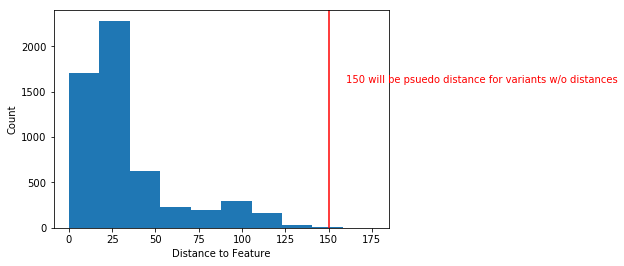

In [40]:
plt.hist(merged['distance_to_feature'].dropna())
plt.xlabel('Distance to Feature')
plt.ylabel('Count')
plt.axvline(x=150,color='r')
plt.text(160,1600,'150 will be psuedo distance for variants w/o distances',color='r')

In [41]:
high_distance = 150

In [42]:
## Keeping NAs
print(merged.shape)
#merged = merged[~merged['distance_to_feature'].isna()]
#merged['distance_to_feature'] = merged['distance_to_feature'].fillna(150)
print(merged.shape)
merged

(7502, 6)
(7502, 6)


,aa,protein,clinvar_path,aa_change,clinvar_index,distance_to_feature
22,65.0,P43489,pathogenic,R=>C,14,45.67
23,1.0,Q96L58,pathogenic,M=>V,15,NaN
24,6.0,Q96L58,pathogenic,R=>W,16,NaN
25,65.0,Q96L58,pathogenic,S=>G,17,15.72
26,67.0,Q96L58,pathogenic,P=>L,18,13.07
27,156.0,Q96L58,pathogenic,D=>N,19,17.46
28,207.0,Q96L58,pathogenic,D=>H,20,38.23
29,217.0,Q96L58,pathogenic,G=>S,21,24.00
30,232.0,Q96L58,pathogenic,R=>C,22,18.44
31,300.0,Q96L58,pathogenic,C=>S,23,NaN


In [43]:
#merged['distance_to_feature'] = merged['distance_to_feature'].fillna(high_distance)

## Filtering sites where distance to feature == 0, which is presumably the glycosylation site

In [44]:
merged = merged[~merged['distance_to_feature'] == 0]
merged.shape

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

## Dropping duplicates for clinvar variants with multiple AA, keeping closest to glycosite

In [32]:
merged = merged.sort_values(by='distance_to_feature',ascending=True).drop_duplicates(subset='clinvar_index',keep='first')

In [35]:
merged.sort_values(by='distance_to_feature')

,aa,protein,clinvar_path,aa_change,clinvar_index,distance_to_feature
43995,400.0,P01009,benign,E=>D,10919,2.88
40668,209.0,O75503,likely pathogenic,Y=>D,9672,3.38
70385,232.0,Q9GZU1,pathogenic,T=>P,16935,3.45
67684,117.0,P02766,pathogenic,A=>S,16442,3.51
155157,550.0,P48029,likely benign,T=>S,37763,3.61
67676,84.0,P02766,pathogenic,F=>L,16433,3.76
5079,483.0,P04062,pathogenic,L=>P,1350,3.76
24772,355.0,P14679,pathogenic,A=>V,6168,4.22
34261,123.0,P55064,pathogenic,N=>D,7529,4.24
111109,445.0,P41180,likely benign,T=>A,25745,4.26


## Dropping duplicated variants really reduces our total # of variants... maybe need to go back to the swiss databank?

In [ ]:
merged.to_csv('../data/clinvar_glycoproteins_distances.txt',sep='\t')